In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE 
from tqdm import *

In [ ]:
##### LOAD DATA INSTEAD OF RUNNING THIS #############################################
# Create "body_skill.csv": csv containging unique, non-nan bodies and associated skill

# load pre-selected dataset
df3 = pd.read_csv('../../data/df3.csv')

# get unique problem text
body = df3['body'].unique()
body.shape

# Confirm that, yes, some problems have the same text
dfsub = df3[['problem_id','body']].drop_duplicates(subset='problem_id')
dfbody = dfsub.groupby('body').count()
# dfbody is how many different problem ids each body is associated with

# Begin processing to get skills for each (I know this is inefficeint...)
body_small = body

body_skill = [] # list of all skills, in orders
body_edited = []
for problem in tqdm(body_small):
    if isinstance(problem, str):
        body_edited.append(problem)
        skill = df3[df3['body'] == problem]['skill_name'].iloc[0] # get the first skill associated with the assistment
        body_skill.append(skill)
        
# save above
body_save=pd.DataFrame({'body': body_edited,
  'skill_name': body_skill})
body_save.to_csv('../../data/body_skill_v2.csv',sep='\t',index=False,columns=['body','skill_name'])

In [74]:
###### LOAD DATA ########
df = pd.read_csv('../../data/body_skill.csv', sep='\t')
body = df['body'].values
skills = df['skill_name'].values


array(['Box and Whisker', 'Box and Whisker', 'Box and Whisker', ..., nan,
       nan, nan], dtype=object)

In [76]:
body_small = body
print(type(body_small))
body_small.shape

def removeHTML(x):
    # Remove not useful characters and HTML text
    x = re.sub('<.*?>', '', x)
    x = re.sub('\n', ' ', x)
    x = re.sub('&nbsp;', '', x)
    x = re.sub('\?', '', x)
    x = re.sub('\\.(\\s)', ' ', x)
    x = re.sub(',', '', x)
    x = re.sub(':', '', x)
    x = re.sub(';', ' ', x)
    x = re.sub('\(', '', x)
    x = re.sub('\)', '', x)
    return x

# Make list of lists of words in each problem
problems = []   # list of lists of words in each problem
wordsAll = []   # list of all words (duplicate words listed more than once)
wordsPerProblem = Counter() # count of how many different problems each word occurred in
for problem in tqdm(body_small):
    if isinstance(problem, str):
        text = removeHTML(problem.lower()) # remove HTML text
        words = text.split() # split into words at white space
        wordsPerProblem += Counter(set(words))
        wordsAll += words
        problems.append(words)
        #print(Counter(set(words)).most_common(), '\n\n')
    
print(len(wordsAll))
print(wordsPerProblem.most_common(20))

  4%|▎         | 720/20123 [00:00<00:02, 7196.56it/s]

<class 'numpy.ndarray'>


100%|██████████| 20123/20123 [00:11<00:00, 1753.05it/s]

667094
[('the', 16770), ('is', 11352), ('of', 10800), ('to', 10210), ('what', 9091), ('in', 7607), ('a', 7568), ('and', 5429), ('for', 4556), ('that', 4511), ('=', 4282), ('below', 4249), ('number', 3913), ('your', 3618), ('3', 3510), ('4', 3435), ('2', 3419), ('answer', 3388), ('now', 3165), ('this', 3135)]


In [81]:
# Look at the most common words in the dataset
commonWords = list(np.array(Counter(wordsAll).most_common(50))[:,0])
print(commonWords)

['the', 'of', 'to', 'is', 'a', 'in', '=', 'what', 'and', 'for', 'number', '2', '3', 'that', '+', '4', 'we', 'below', '1', '6', '5', 'answer', 'on', 'you', 'your', 'this', 'x', '7', 'now', '-', '8', 'each', 'following', 'equation', '10', 'find', 'value', 'as', 'from', 'by', 'how', 'problem', 'are', 'if', 'be', 'use', 'which', 'fraction', 'shows', 'write']


In [133]:
# Create dictionary based on highedt average TFIDF
N = len(problems)
print('Total Number of problems: ',N)

vs = 512 # vocab size
dWordsAll = dict(Counter(wordsAll))
dWordsProb = dict(wordsPerProblem)
dDivide = {k: dWordsAll[k]/N*np.log(N/dWordsProb[k]) for k in dWordsProb.keys() & dWordsAll }
c = Counter(dDivide)
wordDict = list(np.array(c.most_common(vs))[:,0])
print(wordDict)

Total Number of problems:  20123
['=', 'of', 'to', 'a', '2', 'in', 'number', '3', 'we', 'and', 'for', '+', 'the', 'is', '1', 'on', '5', '6', '4', '-', 'x', 'that', 'you', 'what', '7', 'answer', 'below', 'this', '8', 'your', 'each', 'now', 'equation', 'both', 'by', '10', 'from', 'do', 'value', 'write', 'points', 'as', 'following', 'if', 'students', 'find', 'week', 'are', 'fraction', 'how', 'problem', '9', 'sold', 'use', 'be', 'plot', 'day', 'percent', 'which', '12', 'scored', 'will', 'shows', 'has', 'graph', 'one', 'y', 'first', 'type', 'at', 'numbers', 'nearest', 'original', 'order', 'draw', 'between', 'he', 'solve', 'with', 'line', '*', 'stem', 'leaf', '11', 'expression', 'his', 'many', 'example', 'round', 'two', 'know', 'like', 'can', 'have', 'solution', 'favorite', 'there', 'an', 'probability', 'not', 'show', 'try', 'table', '&radic', 'total', 'need', 'operations', 'players', 'games', 'b', 'years', 'was', 'spaces', 'get', '18', 'or', '&divide', '^', '13', 'marble', 'c', 'length', 'a

Number of problems:  20123.0


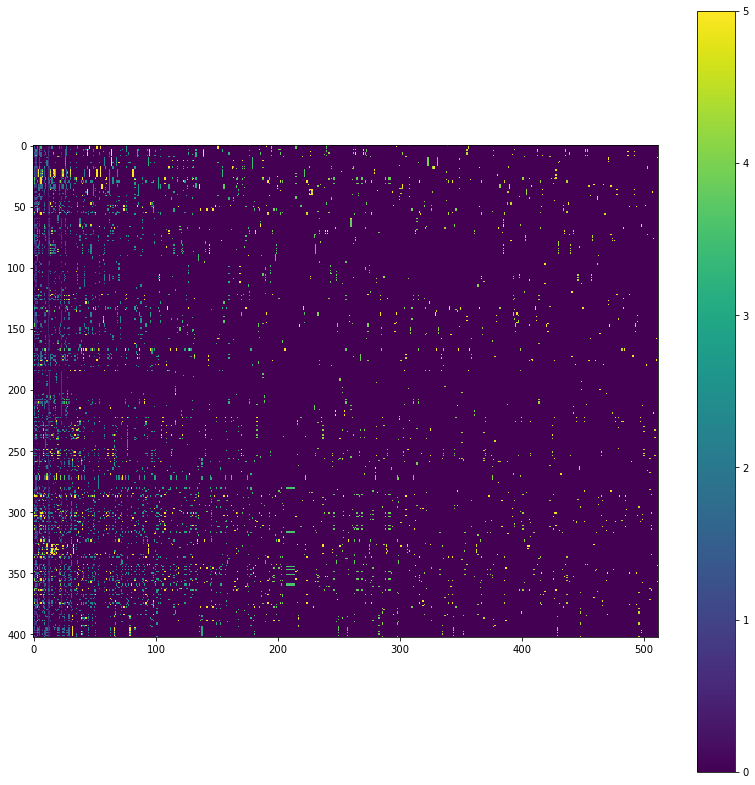

In [135]:
# TF-IDF
# tf_ij: number of times word i appears in problem j
# df_i: number of problems containing word i
# N: number of problems

problems_small = problems
N = float(len(problems))
print('Number of problems: ',N)

tfidf = []
for problem in problems_small:
    c = Counter(problem)
    tfidf_row = []
    for word in wordDict:
        tfidf_row.append(c[word]*np.log(N/wordsPerProblem[word]))
    tfidf.append(np.array(tfidf_row))
    
tfidf = np.array(tfidf)
plt.figure(figsize=(14,14))
plt.imshow(tfidf[::50,:])
plt.colorbar()
plt.clim((0,5))


In [136]:
print(tfidf.shape)

(20123, 512)


In [165]:
# run tsne
tsne=TSNE(perplexity=30,verbose=2) #Instantiate the TSNE model (can change params here)
tfidf_tsne=tsne.fit_transform(xviz) #Run tsne

tsne_save=pd.DataFrame({'x': tfidf_tsne[:,0],
  'y': tfidf_tsne[:,1],
  'skill' : skills_viz})
tsne_save.to_csv('../d3-scatterplot/tsne_body_bagofwords.tsv',sep='\t',index=False,columns=['x','y','skill'])


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2671 samples in 0.118s...
[t-SNE] Computed neighbors for 2671 samples in 4.276s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2671
[t-SNE] Computed conditional probabilities for sample 2000 / 2671
[t-SNE] Computed conditional probabilities for sample 2671 / 2671
[t-SNE] Mean sigma: 3.066360
[t-SNE] Computed conditional probabilities in 0.076s
[t-SNE] Iteration 50: error = 78.0026321, gradient norm = 0.1227260 (50 iterations in 3.959s)
[t-SNE] Iteration 100: error = 75.8936615, gradient norm = 0.0964302 (50 iterations in 3.164s)
[t-SNE] Iteration 150: error = 75.2926788, gradient norm = 0.1129904 (50 iterations in 3.406s)
[t-SNE] Iteration 200: error = 75.1972351, gradient norm = 0.0911028 (50 iterations in 3.038s)
[t-SNE] Iteration 250: error = 75.0939178, gradient norm = 0.1072579 (50 iterations in 3.022s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.093918
[t-SNE] Iteration 300: erro

In [139]:
tfidf_tsne.shape

(2013, 2)

## Visualization Set

## Bag of Words Autoencoder

(18110, 512)
(2013, 512)
(18110,)
(2013,)


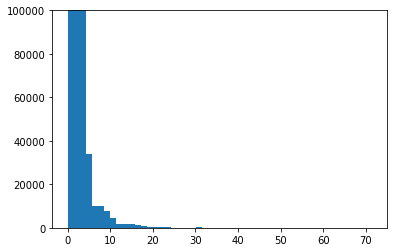

In [203]:
# split bag of words data into training and testing set
xtrain = []
xtest =[]
skills_train = []
skills_test = []
for i in np.arange(tfidf.shape[0]):
    if np.mod(i,10) == 0:
        xtest.append(tfidf[i,:])
        skills_test.append(skills[i])
    else:
        xtrain.append(tfidf[i,:])
        skills_train.append(skills[i])
        
xtrain = np.stack(xtrain, axis=0)
xtest = np.stack(xtest, axis=0)
skills_train = np.stack(skills_train, axis=0)
skills_test = np.stack(skills_test, axis=0)
print(xtrain.shape)
print(xtest.shape)
print(skills_train.shape)
print(skills_test.shape)

# Create visualization set (no nans)
xviz = []
skills_viz = []
for i in np.arange(1,tfidf.shape[0],5):
    if isinstance(skills[i],str):
        xviz.append(tfidf[i,:])
        skills_viz.append(skills[i])
        
xviz = np.stack(xviz, axis=0)
skills_viz = np.stack(skills_viz, axis=0)

plt.hist(np.ndarray.flatten(tfidf), bins=50)
plt.ylim([0, 100000])

norm = 20 # normalization
xtrain = xtrain/norm
xtest = xtest/norm
xviz = xviz/norm

In [209]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
#encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

input_img = Input(shape=(vs,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(vs, activation='sigmoid')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
#encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
# create the decoder model
#decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [212]:
autoencoder.fit(xtrain, xtrain,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(xtest, xtest))

Train on 18110 samples, validate on 2013 samples
Epoch 1/50
18110/18110 [==============================] - 1s - loss: 0.0201 - val_loss: 0.0199

In [215]:
encoded = encoder.predict(xviz)
encoded.shape

(2671, 32)

In [216]:
tsne=TSNE(perplexity=30,verbose=2) #Instantiate the TSNE model (can change params here)
tfidf_tsne=tsne.fit_transform(encoded) #Run tsne
tsne_save=pd.DataFrame({'x': tfidf_tsne[:,0],
  'y': tfidf_tsne[:,1],
  'skill' : skills_viz})
#tsne_save=pd.DataFrame({'x': encoded[:,0],
#  'y': encoded[:,1],
#  'skill' : skills_viz})
tsne_save.to_csv('../d3-scatterplot/tsne_bagofwords_autoencoder.tsv',sep='\t',index=False,columns=['x','y','skill'])


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2671 samples in 0.003s...
[t-SNE] Computed neighbors for 2671 samples in 0.301s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2671
[t-SNE] Computed conditional probabilities for sample 2000 / 2671
[t-SNE] Computed conditional probabilities for sample 2671 / 2671
[t-SNE] Mean sigma: 1.618459
[t-SNE] Computed conditional probabilities in 0.061s
[t-SNE] Iteration 50: error = 75.4327774, gradient norm = 0.0824889 (50 iterations in 3.606s)
[t-SNE] Iteration 100: error = 64.8840866, gradient norm = 0.0185206 (50 iterations in 2.374s)
[t-SNE] Iteration 150: error = 62.5986290, gradient norm = 0.0135926 (50 iterations in 2.377s)
[t-SNE] Iteration 200: error = 61.4771614, gradient norm = 0.0087437 (50 iterations in 2.190s)
[t-SNE] Iteration 250: error = 60.8145676, gradient norm = 0.0054216 (50 iterations in 2.216s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.814568
[t-SNE] Iteration 300: erro

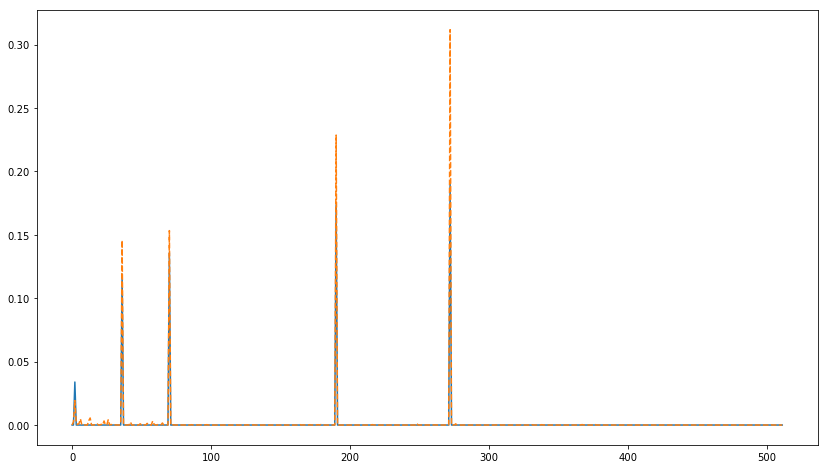

In [219]:
xpred = autoencoder.predict(xviz)
plt.figure(figsize=(14,8))
n = 1000
plt.plot(xviz[n,:])
plt.plot(xpred[n,:], '--')
#print(xpred[n,:])